In [39]:
roi_precision_m1 = {
    '0': 0.5883059671605927,
    '1': 0.2342811373648378,
    '2': 0.11013215859030837,
    '3': 0.054064877853424106,
    '4': 0.05887064477372848,
    '5': 0.016019223067681217,
    '6': 0.003604325190228274,
    '7': 0.1870244293151782,
    '8': 0.22466960352422907,
    '9': 0.002803364036844213,
    'A': 0.0,
    'B': 0.12519809825673534,
    'C': 0.0005336179295624333,
    'D': 0.010651629072681704,
    'E': 0.017857142857142856,
    'F': 0.001070090957731407,
    'G': 0.0021691973969631237,
    'H': 0.0063411540900443885,
    'I': 0.5094231867504283,
    'J': 0.01263823064770932,
    'K': 0.03033528472591804,
    'L': 0.07019438444924406,
    'M': 0.04031413612565445,
    'N': 0.01223404255319149,
    'O': 0.12588171459576777,
    'P': 0.000531632110579479,
    'Q': 0.0,
    'R': 0.0,
    'S': 0.0800211976682565,
    'T': 0.0015706806282722514,
    'U': 0.024390243902439025,
    'V': 0.0,
    'W': 0.0,
    'X': 0.0,
    'Y': 0.17853290183387271,
    'Z': 1.0
}

In [40]:
raw_accuracies_m1 = {
    '0': 0.38846615939126955,
    '1': 0.12815378454144974,
    '2': 0.03886217948717949,
    '3': 0.005606728073688426,
    '4': 0.08890668802563076,
    '5': 0.0024028834601521826,
    '6': 0.00040048057669203043,
    '7': 0.16259511413696437,
    '8': 0.08129755706848218,
    '9': 0.01882258710452543,
    'A': 0.006593406593406593,
    'B': 0.0,
    'C': 0.0,
    'D': 0.0006297229219143577,
    'E': 0.0,
    'F': 0.0079155672823219,
    'G': 0.0,
    'H': 0.005076142131979695,
    'I': 0.7691441441441441,
    'J': 0.0010482180293501049,
    'K': 0.003686150605581885,
    'L': 0.12690631808278868,
    'M': 0.0,
    'N': 0.06898367561874671,
    'O': 0.05024576734025123,
    'P': 0.0,
    'Q': 0.0,
    'R': 0.0,
    'S': 0.0222104706504495,
    'T': 0.00211864406779661,
    'U': 0.015160703456640388,
    'V': 0.0,
    'W': 0.0,
    'X': 0.0,
    'Y': 0.0,
    'Z': 0.0
}

In [41]:
raw_precission_m2 = {
    '0': 0.08970764917901482,
    '1': 0.00040048057669203043,
    '2': 0.031237484981978373,
    '3': 0.004004805766920304,
    '4': 0.0016019223067681217,
    '5': 0.06527833400080096,
    '6': 0.004405286343612335,
    '7': 0.007208650380456548,
    '8': 0.12540064102564102,
    '9': 0.004004805766920304,
    'A': 0.025477707006369428,
    'B': 0.4986835176408636,
    'C': 0.0005305039787798408,
    'D': 0.0,
    'E': 0.0,
    'F': 0.0,
    'G': 0.0005497526113249038,
    'H': 0.0,
    'I': 0.0,
    'J': 0.0,
    'K': 0.0005324813631522897,
    'L': 0.0033130866924351186,
    'M': 0.014255543822597676,
    'N': 0.05514705882352941,
    'O': 0.000550357732526142,
    'P': 0.0005263157894736842,
    'Q': 0.0,
    'R': 0.0,
    'S': 0.0,
    'T': 0.0010570824524312897,
    'U': 0.002962085308056872,
    'V': 0.0,
    'W': 0.0,
    'X': 0.0,
    'Y': 0.0,
    'Z': 0.0
}

In [42]:
roi_precission_m2 = {
    '0': 0.934321185422507,
    '1': 0.32078494193031637,
    '2': 0.13536243492190628,
    '3': 0.0184221065278334,
    '4': 0.28273928714457347,
    '5': 0.1513816579895875,
    '6': 0.06367641169403283,
    '7': 0.048858630356427714,
    '8': 0.18582298758510213,
    '9': 0.09291149379255106,
    'A': 0.03333333333333333,
    'B': 0.1695906432748538,
    'C': 0.001584786053882726,
    'D': 0.023611997447351627,
    'E': 0.0,
    'F': 0.005321979776476849,
    'G': 0.006084070796460177,
    'H': 0.007485963817841547,
    'I': 0.038018433179723504,
    'J': 0.012572027239392353,
    'K': 0.05029745808545159,
    'L': 0.06486486486486487,
    'M': 0.01166489925768823,
    'N': 0.027214514407684097,
    'O': 0.04191295002686728,
    'P': 0.008919202518363064,
    'Q': 0.007312614259597806,
    'R': 0.0,
    'S': 0.027325275880189175,
    'T': 0.00531632110579479,
    'U': 0.007742703990470518,
    'V': 0.0,
    'W': 0.0,
    'X': 0.0,
    'Y': 0.0,
    'Z': 1.0
}

In [43]:
import matplotlib.pyplot as plt
import numpy as np


def plot_character_accuracy(accuracy_dicts, labels, title= ""):
    # Ensure inputs are valid
    if len(accuracy_dicts) != len(labels):
        raise ValueError("The number of dictionaries and labels must be the same.")
    
    # Sort all dictionaries by keys (character order)
    sorted_data = []
    for accuracy_dict in accuracy_dicts:
        sorted_data.append(dict(sorted(accuracy_dict.items())))

    # Extract characters and prepare data
    characters = list(sorted_data[0].keys())  # Assume all dictionaries have the same keys
    accuracies = [list(data.values()) for data in sorted_data]

    # Plot the histogram
    bar_width = 0.4
    x_positions = np.arange(len(characters))

    plt.figure(figsize=(14, 7))
    for i, acc in enumerate(accuracies):
        total_accuracy = sum(acc) / len(acc) 
        plt.bar(x_positions + i * bar_width, acc, bar_width, label=f"{labels[i] } : {total_accuracy:.3f}")
    
    # Formatting the plot
    plt.title(title, fontsize=16)
    plt.xlabel("Characters", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.ylim(0, 1)
    plt.xticks(x_positions + (len(accuracy_dicts) - 1) * bar_width / 2, characters, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

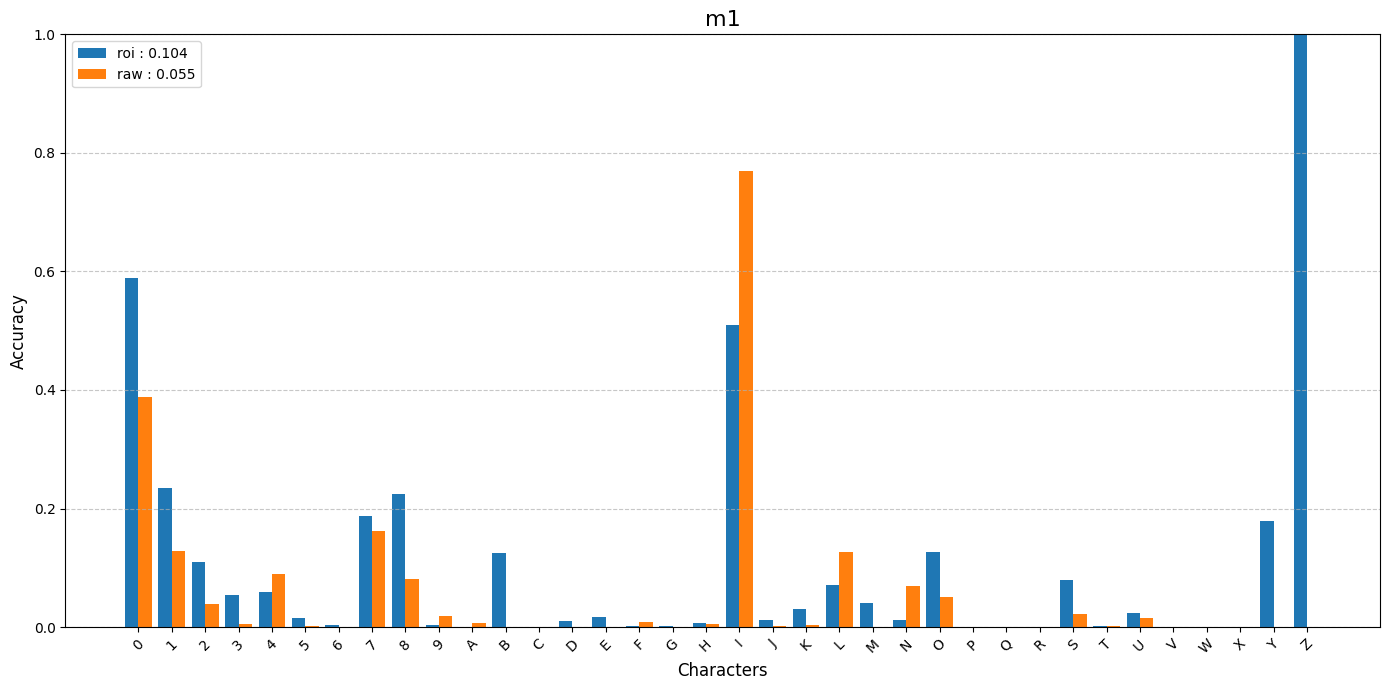

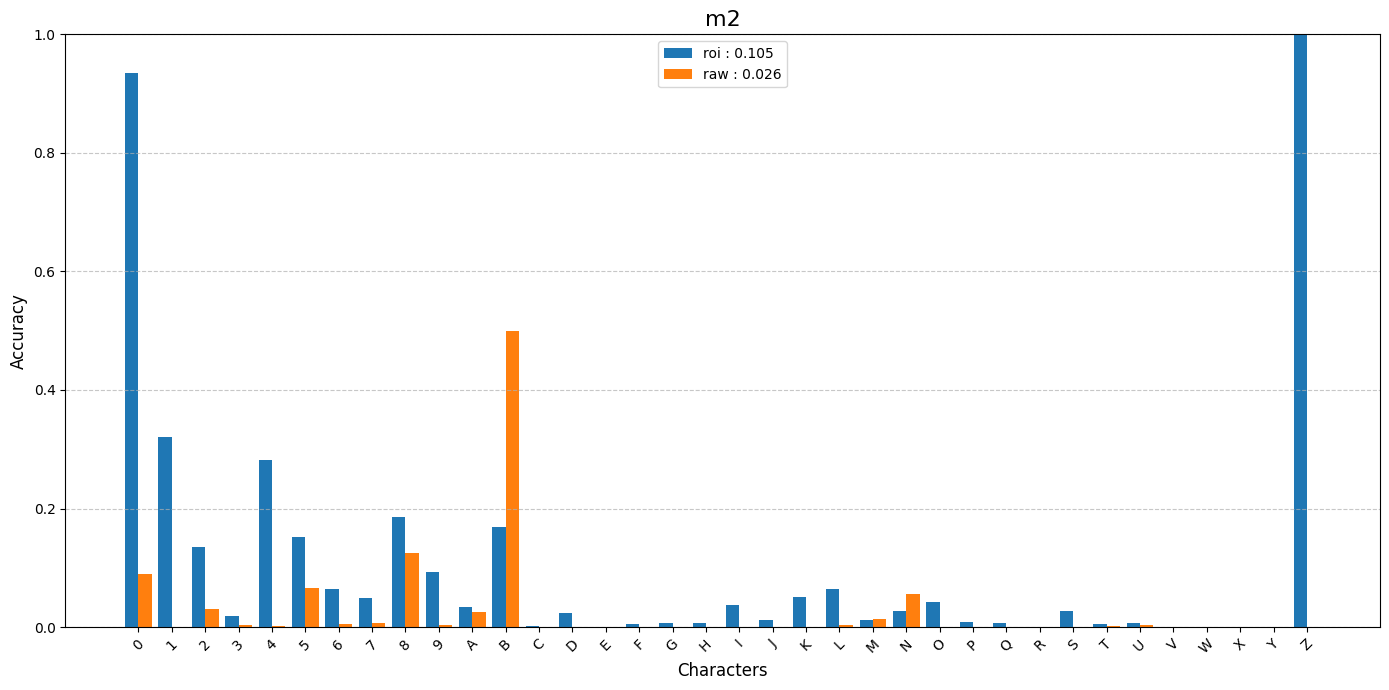

In [45]:
plot_character_accuracy([roi_precision_m1, raw_accuracies_m1], ['roi', 'raw'], "m1")
plot_character_accuracy([roi_precission_m2, raw_precission_m2], ['roi', 'raw'], "m2")